# Customer segmentation
_G. Vrazalis_

___
**1. Data Exploration**

**2. RFM Analysis**
   - 2.1 Recency
   - 2.2 Frequency
     -2.3 Monetary (Order Value)
   - 2.4 Create Recency-Frequency-Monetary table

**3. Customer Segments with Recency-Frequency-Monetary(RFM) model**

   - 3.1 Recency-Frequency-Monetary Quintiles
   - 3.2 Creation of segments 

**4. RFM segmentation to answer business questions**

**5. Creating customer segments based on the total score of the RFM analysis**

**6. Marketing campaign about Coffee and loyal customers**

**7. Conclusion**

# 1. Data Exploration

In [1079]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

In [1080]:
df = pd.read_csv('bq_results_orders_jan2021.csv', parse_dates=['submit_dt'])

In [1081]:
#checking characteristics of the given data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   order_id        400000 non-null  int64              
 1   brand           400000 non-null  object             
 2   submit_dt       400000 non-null  datetime64[ns, UTC]
 3   user_id         400000 non-null  int64              
 4   shop_id         400000 non-null  int64              
 5   city            400000 non-null  object             
 6   cuisine_parent  400000 non-null  object             
 7   basket          400000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(3)
memory usage: 24.4+ MB


In [1082]:
df.head()

,order_id,brand,submit_dt,user_id,shop_id,city,cuisine_parent,basket
0,2846837765,GR-EFOOD,2021-01-13 20:37:06+00:00,99103596,206490318,Βόλος,Healthy / Other,9.0
1,2878146359,GR-EFOOD,2021-01-22 14:28:57+00:00,77179398,206490318,Βόλος,Healthy / Other,7.0
2,2904155390,GR-EFOOD,2021-01-29 13:52:24+00:00,7233822,206490318,Βόλος,Healthy / Other,6.3
3,2867086278,GR-EFOOD,2021-01-19 12:19:59+00:00,68621466,206490318,Βόλος,Healthy / Other,7.0
4,2875723043,GR-EFOOD,2021-01-21 20:08:59+00:00,17007258,206490318,Βόλος,Healthy / Other,11.8


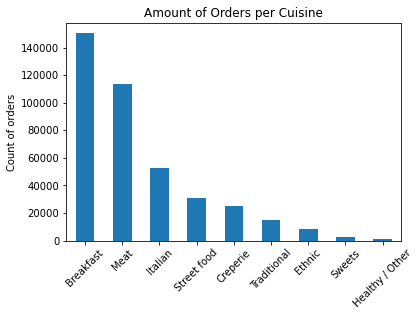

In [1083]:
#different types of cuisines

df.cuisine_parent.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Count of orders')
plt.title('Amount of Orders per Cuisine');

In [1084]:
#percentage of orders per cuisine
df.cuisine_parent.value_counts(normalize=True)

Breakfast          0.375852
Meat               0.284697
Italian            0.131832
Street food        0.076467
Creperie           0.062615
Traditional        0.037605
Ethnic             0.021570
Sweets             0.007112
Healthy / Other    0.002247
Name: cuisine_parent, dtype: float64

In [1085]:
#unique amount of users
df.user_id.nunique()

162954

In [1086]:
df.shop_id.nunique()

3349

In [1087]:
#amount of cities where e-food is being used
df.city.nunique()

91

In [1088]:
#average purchase per order
df.basket.mean()

8.723202149999766

# 2. RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalisation services.

- RECENCY (R): Days since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer. More details about RFM analysis can be found here: https://www.ibm.com/docs/en/spss-statistics/27.0.0?topic=marketing-rfm-analysis

## 2.1 Recency

To calculate recency, (days since last purchase occured), I have to choose a specific point in time to evaluate how many have elapsed since the last purchase of a user.

In [1089]:
latest_date = df['submit_dt'].max().date()
print(f"The latest available date in our dataset is {latest_date}")

The latest available date in our dataset is 2021-01-31


Given that our dataset contains only dates in January 2021, I will use 2021-02-01 as reference date

In [1090]:
ref_date = dt.date(2021,2,1)
print(f"The reference date to approach the problem is: {ref_date}")

The reference date to approach the problem is: 2021-02-01


In [1091]:
# create a new column that contains only the date of every order
df['order_date'] = df['submit_dt'].dt.date

Here I will group users by user_id and check last date of purchase

In [1092]:
recency_df = df.groupby(by='user_id', as_index=False)['order_date'].max()
recency_df.columns = ['user_id','Last_Purshace_Date']
recency_df.head()

,user_id,Last_Purshace_Date
0,27462,2021-01-06
1,39238,2021-01-27
2,41354,2021-01-28
3,44068,2021-01-17
4,49220,2021-01-04


In [1093]:
#recency calculation
recency_df['Recency'] = recency_df['Last_Purshace_Date'].apply(lambda x: (ref_date - x).days)

In [1094]:
recency_df.head()

,user_id,Last_Purshace_Date,Recency
0,27462,2021-01-06,26
1,39238,2021-01-27,5
2,41354,2021-01-28,4
3,44068,2021-01-17,15
4,49220,2021-01-04,28


In [1095]:
#drop Last_Purchase_Date as I don't need it anymore
recency_df = recency_df.drop('Last_Purshace_Date',axis=1)

In [1096]:
recency_df.head()

,user_id,Recency
0,27462,26
1,39238,5
2,41354,4
3,44068,15
4,49220,28


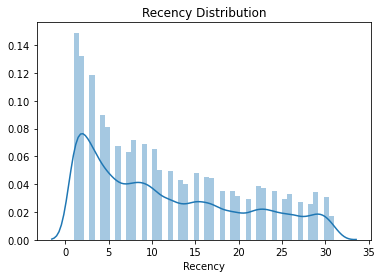

In [1097]:
#Distribution plot for Recency values
sns.distplot(recency_df['Recency'])
plt.title('Recency Distribution');

## 2.2 Frequency

Frequency helps us to know how many times a customer purchased from efood. To do that we need to check how many orders are registered by the same user.

In [1098]:
#calculate frequency of purchases
frequency_df = df.groupby(by=['user_id'], as_index=False)['order_id'].count()
frequency_df.columns = ['user_id','Frequency']
frequency_df.head()

,user_id,Frequency
0,27462,1
1,39238,2
2,41354,4
3,44068,1
4,49220,1


In [1099]:
frequency_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162954 entries, 0 to 162953
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    162954 non-null  int64
 1   Frequency  162954 non-null  int64
dtypes: int64(2)
memory usage: 3.7 MB


In [1100]:
frequency_df.sort_values(by='Frequency', ascending=False)

,user_id,Frequency
115910,106414882,33
56428,50885108,31
48089,42623692,29
40811,36239490,28
98465,88123534,28
...,...,...
76836,68539218,1
76831,68533054,1
76830,68532916,1
76825,68524176,1


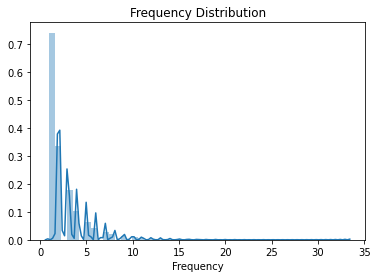

In [1101]:
#Distribution plot for Frequency values
sns.distplot(frequency_df['Frequency'])
plt.title('Frequency Distribution');

## 2.3 Monetary (Order Value)

Monetary attribute answers the question: How much money did the customer spent over time?

To do that, I will calculate the total amount spent per customer from the basket column.

In [1102]:
monetary_df = df.groupby(by='user_id',as_index=False).agg({'basket': 'sum'})
monetary_df.columns = ['user_id','Monetary']
monetary_df.head()

,user_id,Monetary
0,27462,10.6
1,39238,35.0
2,41354,29.0
3,44068,19.5
4,49220,5.3


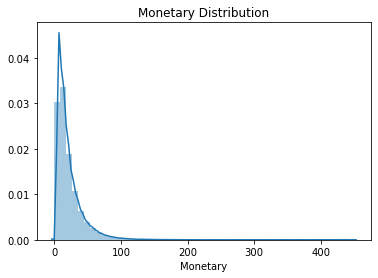

In [1103]:
#Distribution plot for Monetary values
sns.distplot(monetary_df['Monetary'])
plt.title('Monetary Distribution');

## 2.4 Create Recency-Frequency-Monetary table

In [1104]:
rf_df = pd.merge(recency_df, frequency_df, on='user_id')
rf_df.head()

,user_id,Recency,Frequency
0,27462,26,1
1,39238,5,2
2,41354,4,4
3,44068,15,1
4,49220,28,1


In [1105]:
#merge frequency dataframe with monetary dataframe
rfm_df = pd.merge(rf_df, monetary_df,on='user_id')
#use user_id as index
rfm_df = rfm_df.set_index('user_id')
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
user_id,,,
27462,26,1,10.6
39238,5,2,35.0
41354,4,4,29.0
44068,15,1,19.5
49220,28,1,5.3


In [1106]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162954 entries, 27462 to 198285208
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Recency    162954 non-null  int64  
 1   Frequency  162954 non-null  int64  
 2   Monetary   162954 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 5.0 MB


# 3. Customer Segments with Recency-Frequency-Monetary(RFM) model

A good approach to create customers segments from FM Model is to use quintiles. We assign a score from 1 to 5 to Frequency and Monetary columns to give a good level of granularity to our model. This number could alter according to the business needs and targets. In the current approach, five is the best/highest value, and one is the lowest/worst value. The final FM score is calculated  by combining individual Frequency and Monetary score numbers.

## 3.1 Recency-Frequency-Monetary Quintiles

In [1107]:
quintiles = rfm_df.quantile(q=[0.2,0.4,0.6,0.8])
quintiles

,Recency,Frequency,Monetary
0.2,3.0,1.0,7.1
0.4,7.0,1.0,12.2
0.6,12.0,2.0,19.0
0.8,21.0,3.0,31.5


In [1108]:
quintiles.to_dict()

{'Recency': {0.2: 3.0, 0.4: 7.0, 0.6: 12.0, 0.8: 21.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 2.0, 0.8: 3.0},
 'Monetary': {0.2: 7.1, 0.4: 12.2, 0.6: 19.0, 0.8: 31.5}}

## 3.2 Creation of segments

In this section, I will create a function to match the recency, frequency and monetary values with values from one to five. In terms of recency a high  absolute value is bad for our model. On the other hand, frequency and monetary attributes follow the same pattern, the higher the value the better the score. Therefore, I will have to set up two functions in order to clasify those attributes.

In [1109]:
def RecencyScore(x,p,q):
    """ This function matches values of Recency column with relevant quintiles
    x: value
    p: Recency value
    q: quintiles dictionary
    """
    if x <= q[p][0.20]:
        return 5
    elif x <= q[p][0.40]:
        return 4
    elif x <= q[p][0.60]:
        return 3
    elif x <= q[p][0.80]: 
        return 2
    else:
        return 1

In [1110]:
def FMScore(x,p,q):
    """ This function matches values of Frequency and Monetary columns with relevant quintiles
    x: value
    p: Frequency and Monetary values
    q: quintiles dictionary
    """
    if x <= q[p][0.20]:
        return 1
    elif x <= q[p][0.40]:
        return 2
    elif x <= q[p][0.60]:
        return 3
    elif x <= q[p][0.80]: 
        return 4
    else:
        return 5

In [1111]:
#create FM segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quintile'] = rfm_segmentation['Recency'].apply(RecencyScore, args=('Recency',quintiles,))
rfm_segmentation['F_Quintile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quintiles,))
rfm_segmentation['M_Quintile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quintiles,))

In [1112]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile
user_id,,,,,,
27462,26,1,10.6,1,1,2
39238,5,2,35.0,4,3,5
41354,4,4,29.0,4,5,4
44068,15,1,19.5,2,1,4
49220,28,1,5.3,1,1,1


Now that we have the score of each user, we can represent our customer segmentation. To do so, we need to combine the R_Quintile, F_Quintile,M_Quintile scores into a new column which will give us the final score for each customer.

In [1113]:
rfm_segmentation['RFM_Score'] =   rfm_segmentation.R_Quintile.map(str) + rfm_segmentation.F_Quintile.map(str) + rfm_segmentation.M_Quintile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score
user_id,,,,,,,
27462,26,1,10.6,1,1,2,112
39238,5,2,35.0,4,3,5,435
41354,4,4,29.0,4,5,4,454
44068,15,1,19.5,2,1,4,214
49220,28,1,5.3,1,1,1,111


In [1114]:
rfm_segmentation['Total_score'] = rfm_segmentation['R_Quintile'] + rfm_segmentation['F_Quintile'] + rfm_segmentation['M_Quintile']
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score
user_id,,,,,,,,
27462,26,1,10.6,1,1,2,112,4
39238,5,2,35.0,4,3,5,435,12
41354,4,4,29.0,4,5,4,454,13
44068,15,1,19.5,2,1,4,214,7
49220,28,1,5.3,1,1,1,111,3


Score Explanation:
- Best Recency score = 5 : User with the most recent purchase
- Best Frequency score = 5 : User with most quantities purchased
- Best Monetary score = 5 : User who spent the most amount of money
- Least Recency score = 1 : User with the least recent purchase
- Least Frequency score = 1 : User with least quantities purchased
- Least Monetary score = 1 : User who spent the least amount of money

Therefore, the user with best/highest score  will be represented with '555'  in the RFM_Score column while the user with the worst/lowest score will be represented with '111' score in the RFM_score column
    

# 4. RFM segmentation to answer business questions

Following the RFM analysis, we are now able to answer some critical answers for the business. Some of these can be found below:

### Who are the best customers for the business?

In [1115]:
#customers who got a score of 5 in every metric
rfm_segmentation[rfm_segmentation['RFM_Score']=='555'].head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score
user_id,,,,,,,,
139150,1,4,31.8,5,5,5,555,15
153962,2,7,47.1,5,5,5,555,15
168498,3,8,100.1,5,5,5,555,15
170016,1,7,63.4,5,5,5,555,15
192832,2,9,71.0,5,5,5,555,15


### Which customers are at the verge of churning?

In [1116]:
# Customers with low recency value
rfm_segmentation[rfm_segmentation['R_Quintile'] <=2].head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score
user_id,,,,,,,,
27462,26,1,10.6,1,1,2,112,4
44068,15,1,19.5,2,1,4,214,7
49220,28,1,5.3,1,1,1,111,3
51842,16,1,20.2,2,1,4,214,7
55062,21,2,29.3,2,3,4,234,9


### Who are the lost customers?

In [1117]:
# Customers with low Recency, Frequency and Monetary values
rfm_segmentation[rfm_segmentation['RFM_Score']=='111'].head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score
user_id,,,,,,,,
49220,28,1,5.3,1,1,1,111,3
112884,24,1,7.0,1,1,1,111,3
122038,25,1,6.8,1,1,1,111,3
224158,28,1,2.0,1,1,1,111,3
268364,27,1,1.7,1,1,1,111,3


### Who are the loyal customers?

In [1118]:
# Customers with high frequency value
rfm_segmentation[rfm_segmentation['F_Quintile']==5].head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score
user_id,,,,,,,,
41354,4,4,29.0,4,5,4,454,13
52532,10,8,74.1,3,5,5,355,13
64538,2,4,27.1,5,5,4,554,14
97244,9,5,18.0,3,5,3,353,11
135792,11,4,48.3,3,5,5,355,13


### Which customers are spending the most ?

In [1119]:
## Customers with high monetary value
rfm_segmentation[rfm_segmentation['M_Quintile']==5].head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score
user_id,,,,,,,,
39238,5,2,35.0,4,3,5,435,12
52532,10,8,74.1,3,5,5,355,13
85008,3,1,53.1,5,1,5,515,11
101522,4,1,34.1,4,1,5,415,10
113528,13,2,33.2,2,3,5,235,10


Below can be found the total amount of users that fall into the five critical business questions above:

In [1120]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_Score']=='555']))
print("Churning Customers: ",len(rfm_segmentation[rfm_segmentation['R_Quintile']<=2]))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quintile']==5]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quintile']==5]))

Best Customers:  10895
Churning Customers:  64676
Lost Customers:  9211
Loyal Customers:  31952
Big Spenders:  32536


# 5. Creating customer segments based on the total score of the RFM analysis

Taking advantage of the total score column, we could create more segments based on common segment names. There are various examples that are widely used in e-commerce. Some examples and explanations could be found here: https://www.putler.com/rfm-analysis/

It has to be highlighted that the name and levels of segments could be altered according to business needs and requirements. 

In [1121]:
# Define rfm_segment function
def rfm_segments(df):
    if df['Total_score'] >= 13:
        return 'Champions'
    elif ((df['Total_score'] >= 10) and (df['Total_score'] < 13)):
        return 'Cannot Lose them'
    elif ((df['Total_score'] >= 8) and (df['Total_score'] < 10)):
        return 'Potential Loyalist'
    elif ((df['Total_score'] >= 7) and (df['Total_score'] < 8)):
        return 'Promising'
    elif ((df['Total_score'] >= 5) and (df['Total_score'] < 7)):
        return 'About to sleep'
    elif ((df['Total_score'] >= 4) and (df['Total_score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [1122]:
rfm_segmentation['RFM_segments'] =  rfm_segmentation.apply(rfm_segments, axis=1)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score,RFM_segments
user_id,,,,,,,,,
27462,26,1,10.6,1,1,2,112,4,Needs Attention
39238,5,2,35.0,4,3,5,435,12,Cannot Lose them
41354,4,4,29.0,4,5,4,454,13,Champions
44068,15,1,19.5,2,1,4,214,7,Promising
49220,28,1,5.3,1,1,1,111,3,Require Activation


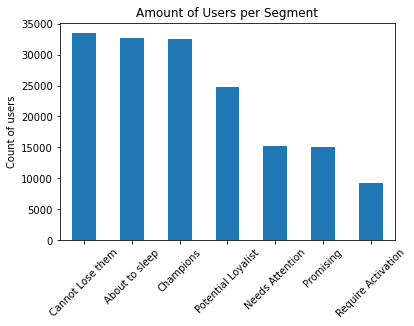

In [1123]:
rfm_segmentation['RFM_segments'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Count of users')
plt.title('Amount of Users per Segment');

In [1124]:
rfm_segmentation.RFM_segments.value_counts()

Cannot Lose them      33486
About to sleep        32634
Champions             32456
Potential Loyalist    24824
Needs Attention       15244
Promising             15099
Require Activation     9211
Name: RFM_segments, dtype: int64

In [1125]:
rfm_segmentation.RFM_segments.value_counts(normalize=True)*100

Cannot Lose them      20.549357
About to sleep        20.026511
Champions             19.917277
Potential Loyalist    15.233747
Needs Attention        9.354787
Promising              9.265805
Require Activation     5.652515
Name: RFM_segments, dtype: float64

In [1126]:
# Calculate average values for each RFM_segment, and return a size of each segment 
rfm_segment_values = rfm_segmentation.groupby('RFM_segments').agg({'Recency': 'mean','Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)
rfm_segment_values.columns = rfm_segment_values.columns.droplevel()
rfm_segment_values.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_segment_values['Percentage'] = ((rfm_segment_values['Count']/rfm_segment_values.Count.sum()).round(4)*100).astype(str) + '%'

In [1127]:
rfm_segment_values

,RecencyMean,FrequencyMean,MonetaryMean,Count,Percentage
RFM_segments,,,,,
About to sleep,16.2,1.1,10.8,32634,20.03%
Cannot Lose them,7.6,2.8,25.0,33486,20.549999999999997%
Champions,3.6,5.8,47.6,32456,19.919999999999998%
Needs Attention,21.5,1.0,7.1,15244,9.35%
Potential Loyalist,10.4,1.7,16.6,24824,15.229999999999999%
Promising,10.7,1.3,12.4,15099,9.27%
Require Activation,26.4,1.0,4.9,9211,5.65%


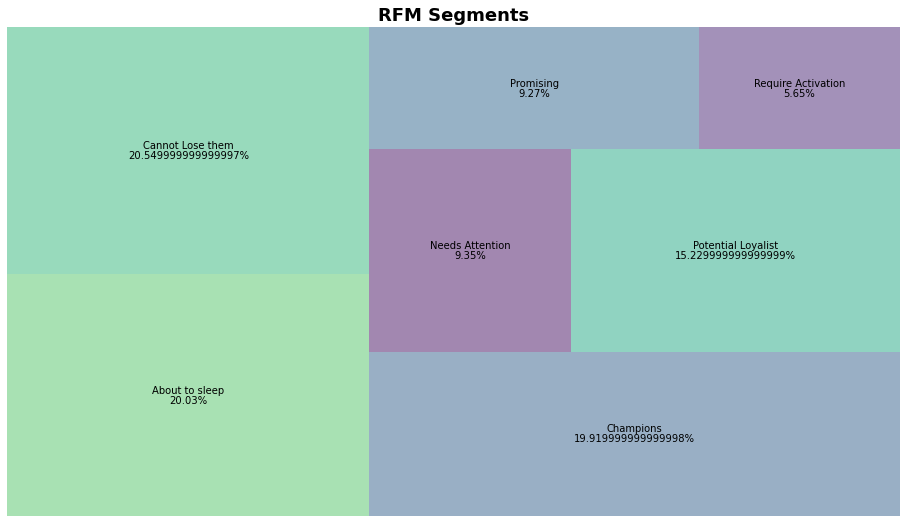

In [1128]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_segment_values['Count'], 
              label=rfm_segment_values.index, value=rfm_segment_values['Percentage'], alpha=.5 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# 6. Marketing campaign about Coffee and loyal customers

In [1129]:
#Identify the loyal customers based on the Frequency Quintile of the RFM analysis
loyal_customers = rfm_segmentation[rfm_segmentation['F_Quintile']==5]
loyal_customers

,Recency,Frequency,Monetary,R_Quintile,F_Quintile,M_Quintile,RFM_Score,Total_score,RFM_segments
user_id,,,,,,,,,
41354,4,4,29.00,4,5,4,454,13,Champions
52532,10,8,74.10,3,5,5,355,13,Champions
64538,2,4,27.10,5,5,4,554,14,Champions
97244,9,5,18.00,3,5,3,353,11,Cannot Lose them
135792,11,4,48.30,3,5,5,355,13,Champions
...,...,...,...,...,...,...,...,...,...
197483290,2,4,12.40,5,5,3,553,13,Champions
197492030,2,4,50.20,5,5,5,555,15,Champions
197497090,3,5,14.40,5,5,3,553,13,Champions


In [1130]:
# Match user_id of the royal dataframe with the users from the initial table (df)
df_loyal = df[df['user_id'].isin(loyal_customers.index)]

In [1131]:
df_loyal = df_loyal.groupby(by=['cuisine_parent'], as_index=False).agg({'order_id':'count'})
df_loyal = df_loyal.sort_values(by='order_id', ascending = False)

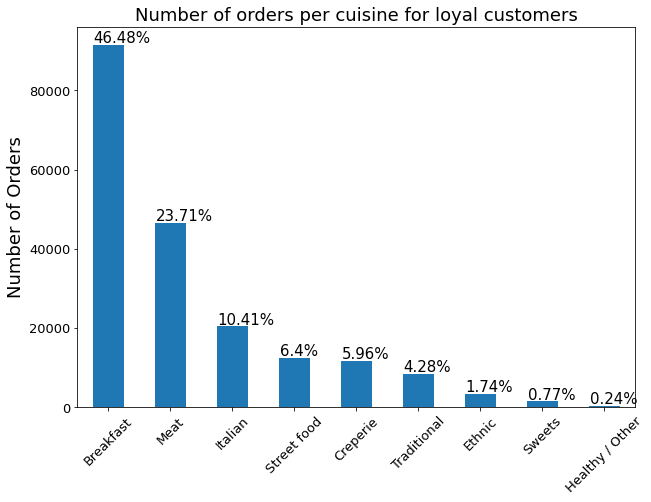

In [1132]:
ax = df_loyal.plot(kind='bar', figsize=(10,7), fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Number of orders per cuisine for loyal customers", fontsize=18)
ax.set_ylabel("Number of Orders", fontsize=18);
ax.set_xticklabels(df_loyal['cuisine_parent'])
ax.legend().set_visible(False)
plt.xticks(rotation =45)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.01, i.get_height()+500, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15)

# 7. Conclusion

Now that the customer segments have been established, it is time to target or delve deeper into a segment that seems interesting. It has to be noted one more time that the segments that have been set up for the purpose of this assessment could be altered according to the company's needs and requirements.

Some examples about the next steps after the customer segmentation could be:
1. Reward the best customers . As they use the application a lot, they could get a credit bonus if they refer a friend for example.
2.  Churning customers. Send them personalised emails to encourage them to shop
3. Loyal customers. Examine segments to identify latest trends and create new Marketing campaigns (coffee cuisine example)